In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt

from pyspark import SparkConf
from pyspark.sql import SparkSession # Spark SQL
from pyspark.sql.functions import date_format, to_date
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType, TimestampType

import pyspark.sql.functions as F
from pyspark.sql.functions import udf

master = "local[10]"
app_name = "Parallel Join"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)#.set("spark.executor.memory", "6g")
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

pd.set_option('display.max_colwidth', None)

23/06/30 00:43:53 WARN Utils: Your hostname, crarojasca-Blade-14-RZ09-0370 resolves to a loopback address: 127.0.1.1; using 192.168.1.9 instead (on interface wlp2s0)
23/06/30 00:43:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/30 00:43:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/30 00:43:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Load Hamburg Data
file = "../datasets/hamburg/omm_export_tweets_01-06-2022_v2.csv"
data = spark.read.options(delimiter="\t").csv(file, header=True)

# Load CARDS Predictions
schema = StructType([
    StructField("id_cards", StringType(), True),
    StructField("cards_pred", StringType(), True),
    StructField("cards_pred_score", FloatType(), True)])

file = "../datasets/predictions"
predictions = spark.read.options(delimiter="|").csv(file, header=False, schema=schema)

# Load Waterloo+CARDS Predictions
schema = StructType([
    StructField("id_waterloo_cards", StringType(), True),
    StructField("waterloo_cards_pred", StringType(), True),
    StructField("waterloo_cards_score", FloatType(), True)])

file = "../datasets/predictions_waterloo_cards"
new_predictions = spark.read.options(delimiter="|").csv(file, header=False, schema=schema)

data = data.join(
    predictions, data.id ==  predictions.id_cards, "inner"
).join(
    new_predictions, data.id ==  new_predictions.id_waterloo_cards, "inner"
).drop(
    "id_cards", "id_waterloo_cards"
)

@udf(returnType=TimestampType())
def generateDate(year, month, day):
    if not year or not month or not day:
        return
    try:
        date = year + "-" + month + "-" + day
        return datetime.strptime(date,"%Y-%m-%d") 
    except:
        return

data = (
    data.withColumn("year", data.year.cast(StringType()))
    .withColumn("month", data.month.cast(StringType()))
    .withColumn("day", data.day.cast(StringType()))
)

data = (
    data.withColumn("date", generateDate(data.year, data.month, data.day))
)

data = data.withColumn("date", date_format("date", "yyyy-MM-dd HH:mm:ss"))
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- username: string (nullable = true)
 |-- fulltext: string (nullable = true)
 |-- 140_char_text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- url: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- favorite_count: string (nullable = true)
 |-- language: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_time_zone: string (nullable = true)
 |-- user_follower_count: string (nullable = true)
 |-- user_favorite_count: string (nullable = true)
 |-- user_tweet_count: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- media: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- minute: 

In [4]:
total_count = data.count()

In [6]:
data.filter(F.col("waterloo_cards_score")>0.999).count()/total_count

0.7607414056531704

In [7]:
count = data.filter(F.col("waterloo_cards_score")>0.999).groupby(F.col("waterloo_cards_pred")).count().toPandas()

23/06/30 00:47:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/30 00:47:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/30 00:47:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/30 00:47:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/30 00:47:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/30 00:47:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/30 00:47:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/30 00:47:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/30 00:47:51 WARN RowBasedKeyValueBatch: Calling spill() on

In [9]:
count["prop"] = count["count"]/total_count

In [10]:
count

,waterloo_cards_pred,count,prop
0,0,3854597,0.736172
1,1,128645,0.024569


In [11]:
scores_bins = data.select('waterloo_cards_score').rdd.flatMap(lambda x: x).histogram(20)

In [15]:
scores = pd.DataFrame(
    list(zip(*scores_bins)), 
    columns=['bin', 'frequency']
)
scores["prop"] = scores["frequency"]/total_count
scores

,bin,frequency,prop
0,0.500000,1258,0.000240
1,0.524999,1191,0.000227
2,0.549997,1286,0.000246
3,0.574996,1302,0.000249
4,0.599994,1352,0.000258
5,0.624993,1308,0.000250
6,0.649992,1479,0.000282
7,0.674990,1561,0.000298
8,0.699989,1629,0.000311
9,0.724987,1748,0.000334


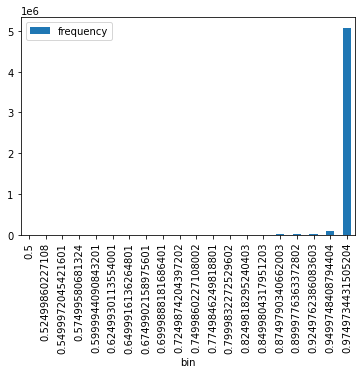

In [14]:
scores.set_index(
    'bin'
).plot(kind='bar');

In [17]:
scores_bins = data.select('cards_pred_score').rdd.flatMap(lambda x: x).histogram(20)

In [18]:
scores = pd.DataFrame(
    list(zip(*scores_bins)), 
    columns=['bin', 'frequency']
)
scores["prop"] = scores["frequency"]/total_count
scores

,bin,frequency,prop
0,0.184304,17,0.000003
1,0.225081,95,0.000018
2,0.265858,383,0.000073
3,0.306635,1028,0.000196
4,0.347412,2352,0.000449
5,0.388189,3831,0.000732
6,0.428966,5900,0.001127
7,0.469743,14646,0.002797
8,0.510520,22707,0.004337
9,0.551297,23364,0.004462


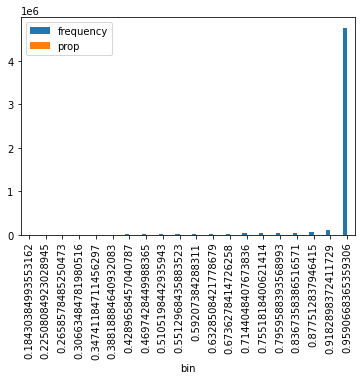

In [19]:
scores.set_index(
    'bin'
).plot(kind='bar');